https://arxiv.org/abs/1512.03385  
这篇论文首次提出了残差网络（ResNet）的概念，解决了深层网络训练中梯度消失和退化问题。核心思想是通过“恒等映射”短路（skip connection）来学习残差函数，让网络更容易优化。  

1. ResNet‑18 网络结构  
ResNet‑18 是 ResNet 系列中较浅的一种，包含 18 层可学习层（不计入 ReLU、池化等层）。其大致结构如下：  

Input (224×224×3)  
↓  
7×7 conv, stride=2, 64 filters  
3×3 max pool, stride=2  
↓  
[ 2 × (3×3 conv, 64 filters) ]   ← Residual Block ×2  
[ 2 × (3×3 conv, 128 filters) ]  ← Residual Block ×2 (first block stride=2)  
[ 2 × (3×3 conv, 256 filters) ]  ← Residual Block ×2 (first block stride=2)  
[ 2 × (3×3 conv, 512 filters) ]  ← Residual Block ×2 (first block stride=2)  
↓  
Global Average Pooling  
Fully Connected (512 → 1000 for ImageNet)  
Softmax  
每个 Residual Block 都包含两层 3×3 卷积和一次跳跃连接（identity shortcut）。  
在通道数扩张的那一层（如 64→128），使用 1×1 卷积在 shortcut 分支上做下采样和升维。  

2. 关键设计理念  
残差学习（Residual Learning）  
原始网络学习目标映射 H(x)，而 ResNet 学习残差 F(x) = H(x) − x，最后输出 F(x) + x。  
这样做能让深层网络更容易优化，减少梯度消失。  
短路连接（Skip Connection）  
恒等映射直接将输入 x 加到后面层的输出上。  
保证信息和梯度可以跨层直接传递。  
批量归一化（Batch Normalization）  
在每次卷积后都加 BN，加速收敛并稳定训练。  

3. 资源与教程  
官方 PyTorch 文档  
ResNet 源码和使用示例：https://pytorch.org/vision/stable/models.html#id14  
博客与解读  
“A Guide to ResNet” by Lilian Weng：https://lilianweng.github.io/lil-log/2017/12/31/residual-networks.html  
“Deep Residual Networks Explained” by Brandon Amos：https://amitness.com/2019/05/resnets-explained/  
视频课程  
Stanford CS231n Lecture on ResNet：https://www.youtube.com/watch?v=Z2tP6B_3b2o  

In [2]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class AerialDataset(Dataset):
    """空中景观数据集类，支持训练/验证/测试数据划分"""
    def __init__(self, root_dir, transform=None, split_ratio=[0.6, 0.2, 0.2], mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.split_ratio = split_ratio
        self.mode = mode
        self.imgs = self._load_images()

    def _load_images(self):
        imgs = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            img_files = sorted(os.listdir(class_path))

            # 计算每个集合的图像数量
            total_images = len(img_files)
            train_size = int(total_images * self.split_ratio[0])
            val_size = int(total_images * self.split_ratio[1])

            # 根据模式选择相应的图像
            if self.mode == 'train':
                selected_files = img_files[:train_size]
            elif self.mode == 'val':
                selected_files = img_files[train_size:train_size + val_size]
            else:  # test
                selected_files = img_files[train_size + val_size:]

            for img_name in selected_files:
                imgs.append((os.path.join(class_path, img_name), self.class_to_idx[cls]))
        return imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


def get_transforms(augmentation_strategy='default'):
    """获取数据预处理与增强的transforms

    参数:
    augmentation_strategy: 增强策略，可选 'default', 'minimal', 'extensive'
    """
    if augmentation_strategy == 'minimal':
        # 最小数据增强
        train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif augmentation_strategy == 'extensive':
        # 广泛数据增强
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
            transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2)
        ])
    else:  # default
        # 默认数据增强
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
            transforms.RandomSolarize(threshold=0.5, p=0.2),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    # 验证和测试集的transform保持不变
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform


def create_dataloaders(root_dir, batch_size=32, split_ratio=[0.6, 0.2, 0.2],
                       augmentation_strategy='default', random_seed=42, num_workers=0, verbose=True):
    """创建数据加载器

    参数:
    root_dir: 数据集根目录
    batch_size: 批次大小
    split_ratio: 训练集、验证集、测试集的划分比例，如[0.6, 0.2, 0.2]
    augmentation_strategy: 数据增强策略，可选 'default', 'minimal', 'extensive'
    random_seed: 随机种子
    num_workers: 数据加载线程数，Windows下建议设为0
    verbose: 是否打印详细信息

    返回:
    train_loader, val_loader, test_loader, classes
    """
    # 设置随机种子
    if random_seed is not None:
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    if verbose:
        print(f"Create dataloader: batch_size={batch_size}, split_ratio={split_ratio}, augmentation={augmentation_strategy}...")

    # 获取数据预处理与增强
    train_transform, val_test_transform = get_transforms(augmentation_strategy)

    # 创建数据集
    train_dataset = AerialDataset(root_dir=root_dir, transform=train_transform,
                                  split_ratio=split_ratio, mode='train')
    val_dataset = AerialDataset(root_dir=root_dir, transform=val_test_transform,
                                split_ratio=split_ratio, mode='val')
    test_dataset = AerialDataset(root_dir=root_dir, transform=val_test_transform,
                                 split_ratio=split_ratio, mode='test')

    if verbose:
        print(f"Dataset size - train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")

        # 打印每个类的数据分布
        class_counts = {}
        for _, label in train_dataset.imgs:
            class_name = train_dataset.classes[label]
            if class_name not in class_counts:
                class_counts[class_name] = 1
            else:
                class_counts[class_name] += 1

        print("Classes distribution:")
        for cls, count in sorted(class_counts.items()):
            print(f"- {cls}: {count} images")

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_dataset.classes

In [8]:
def build_model(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def train_one_epoch(model, loader, crit, opt, device):
    model.train()
    loss_sum = correct = total = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = crit(out,y)
        loss.backward()
        opt.step()
        preds = out.argmax(1)
        loss_sum += loss.item()*x.size(0)
        correct += (preds==y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

def eval_one_epoch(model, loader, crit, device):
    model.eval()
    loss_sum = correct = total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = crit(out,y)
            preds = out.argmax(1)
            loss_sum += loss.item()*x.size(0)
            correct += (preds==y).sum().item()
            total += x.size(0)
    return loss_sum/total, correct/total

def plot_save(history, cm, classes, strategy):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'],   label='Val Loss')
    plt.title(f'Loss-{strategy}'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'],   label='Val Acc')
    plt.title(f'Acc-{strategy}'); plt.legend()
    plt.tight_layout()
    plt.savefig(f'curves_{strategy}.png')
    plt.close()

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'CM-{strategy}')
    plt.savefig(f'cm_{strategy}.png')
    plt.close()


In [4]:
# 超参数
DATA_DIR = "./Aerial_Landscapes"
SPLIT    = [0.6,0.2,0.2]
BATCH    = 32
EPOCHS   = 20
LR       = 1e-4
WD       = 1e-5
PATIENCE_ES = 5

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = {}

for strat in ['minimal','default','extensive']:
    print(f"\n=== Strategy: {strat} ===")
    trn, val, tst, classes = create_dataloaders(
        DATA_DIR, BATCH, SPLIT, strat, random_seed=42, num_workers=0, verbose=True)

    model = build_model(len(classes)).to(device)
    crit  = nn.CrossEntropyLoss()
    opt   = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_val_loss = float('inf')
    es_cnt = 0
    history = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

    for ep in range(EPOCHS):
        tr_l, tr_a = train_one_epoch(model, trn, crit, opt, device)
        val_l, val_a = eval_one_epoch(model, val, crit, device)
        history['train_loss'].append(tr_l)
        history['val_loss'].append(val_l)
        history['train_acc'].append(tr_a)
        history['val_acc'].append(val_a)
        print(f"Epoch {ep+1}/{EPOCHS} | Train {tr_l:.4f}/{tr_a:.4f} | Val {val_l:.4f}/{val_a:.4f}")

        if val_l < best_val_loss:
            best_val_loss = val_l
            torch.save(model.state_dict(), f'best_{strat}.pth')
            es_cnt = 0
        else:
            es_cnt += 1
            if es_cnt >= PATIENCE_ES:
                print("Early stopping.")
                break

    # 测试
    y_true = []
    y_pred = []
    
    model.load_state_dict(torch.load(f'best_{strat}.pth'))
    model.eval()
    with torch.no_grad():
        for x,y in tst:
            x,y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=classes)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Acc: {acc:.4f}")
    print(report)
    plot_save(history, cm, classes, strat)
    results[strat] = acc

# %% [markdown]
# ## 4. 对比结果

# %%
for strat, acc in results.items():
    print(f"{strat}: Test Accuracy = {acc:.4f}")


=== Strategy: minimal ===
Create dataloader: batch_size=32, split_ratio=[0.6, 0.2, 0.2], augmentation=minimal...
Dataset size - train: 7200, val: 2400, test: 2400
Classes distribution:
- Agriculture: 480 images
- Airport: 480 images
- Beach: 480 images
- City: 480 images
- Desert: 480 images
- Forest: 480 images
- Grassland: 480 images
- Highway: 480 images
- Lake: 480 images
- Mountain: 480 images
- Parking: 480 images
- Port: 480 images
- Railway: 480 images
- Residential: 480 images
- River: 480 images
Epoch 1/20 | Train 0.4358/0.8799 | Val 0.3040/0.9062
Epoch 2/20 | Train 0.1252/0.9661 | Val 0.2499/0.9221
Epoch 3/20 | Train 0.0714/0.9806 | Val 0.2695/0.9167
Epoch 4/20 | Train 0.0519/0.9860 | Val 0.2294/0.9317
Epoch 5/20 | Train 0.0418/0.9888 | Val 0.2200/0.9371
Epoch 6/20 | Train 0.0258/0.9944 | Val 0.2332/0.9317
Epoch 7/20 | Train 0.0324/0.9917 | Val 0.2886/0.9179
Epoch 8/20 | Train 0.0252/0.9926 | Val 0.2301/0.9367
Epoch 9/20 | Train 0.0329/0.9904 | Val 0.2403/0.9371
Epoch 10/20

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train 0.7114/0.7851 | Val 0.5063/0.8517
Epoch 2/20 | Train 0.3281/0.8964 | Val 0.3851/0.8750
Epoch 3/20 | Train 0.2663/0.9131 | Val 0.4004/0.8729
Epoch 4/20 | Train 0.2183/0.9308 | Val 0.3257/0.9058
Epoch 5/20 | Train 0.2039/0.9351 | Val 0.2686/0.9167
Epoch 6/20 | Train 0.1787/0.9418 | Val 0.2432/0.9300
Epoch 7/20 | Train 0.1639/0.9468 | Val 0.2941/0.9175
Epoch 8/20 | Train 0.1539/0.9531 | Val 0.2694/0.9171
Epoch 9/20 | Train 0.1395/0.9536 | Val 0.2680/0.9229
Epoch 10/20 | Train 0.1102/0.9651 | Val 0.3098/0.9100
Epoch 11/20 | Train 0.1236/0.9601 | Val 0.2643/0.9208
Early stopping.
Test Acc: 0.9450
              precision    recall  f1-score   support

 Agriculture       0.98      0.90      0.94       160
     Airport       0.84      0.96      0.89       160
       Beach       0.94      0.93      0.93       160
        City       0.92      0.89      0.91       160
      Desert       0.99      0.91      0.94       160
      Forest       1.00      0.97      0.98       160
   

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train 0.8952/0.7258 | Val 0.6589/0.8067
Epoch 2/20 | Train 0.4791/0.8443 | Val 0.5581/0.8279
Epoch 3/20 | Train 0.4072/0.8711 | Val 0.4554/0.8662
Epoch 4/20 | Train 0.3604/0.8792 | Val 0.4004/0.8712
Epoch 5/20 | Train 0.3476/0.8876 | Val 0.4280/0.8717
Epoch 6/20 | Train 0.2985/0.9025 | Val 0.4269/0.8738
Epoch 7/20 | Train 0.3044/0.9011 | Val 0.3948/0.8938
Epoch 8/20 | Train 0.2742/0.9118 | Val 0.4071/0.8825
Epoch 9/20 | Train 0.2502/0.9179 | Val 0.2913/0.9171
Epoch 10/20 | Train 0.2587/0.9204 | Val 0.3184/0.9075
Epoch 11/20 | Train 0.2519/0.9190 | Val 0.3629/0.8967
Epoch 12/20 | Train 0.2267/0.9260 | Val 0.3733/0.8967
Epoch 13/20 | Train 0.2316/0.9236 | Val 0.3537/0.9042
Epoch 14/20 | Train 0.2185/0.9290 | Val 0.3845/0.8929
Early stopping.
Test Acc: 0.9379
              precision    recall  f1-score   support

 Agriculture       0.94      0.96      0.95       160
     Airport       0.95      0.89      0.92       160
       Beach       0.99      0.89      0.94       160
   


=== Confusion Matrix for strategy: minimal ===


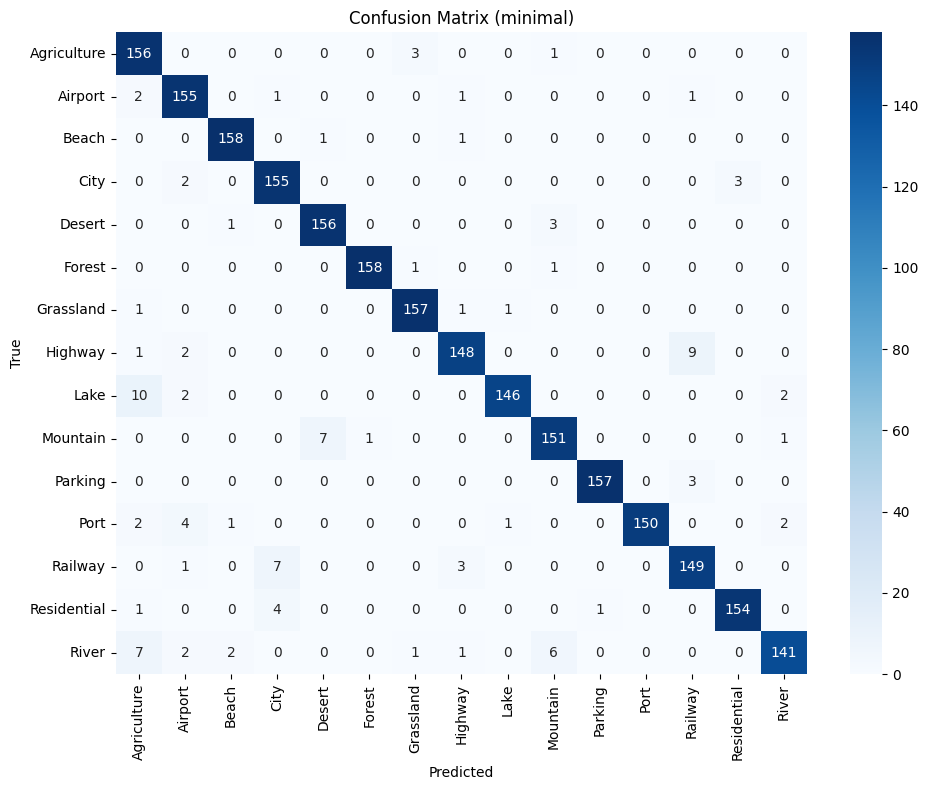


=== Confusion Matrix for strategy: default ===


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


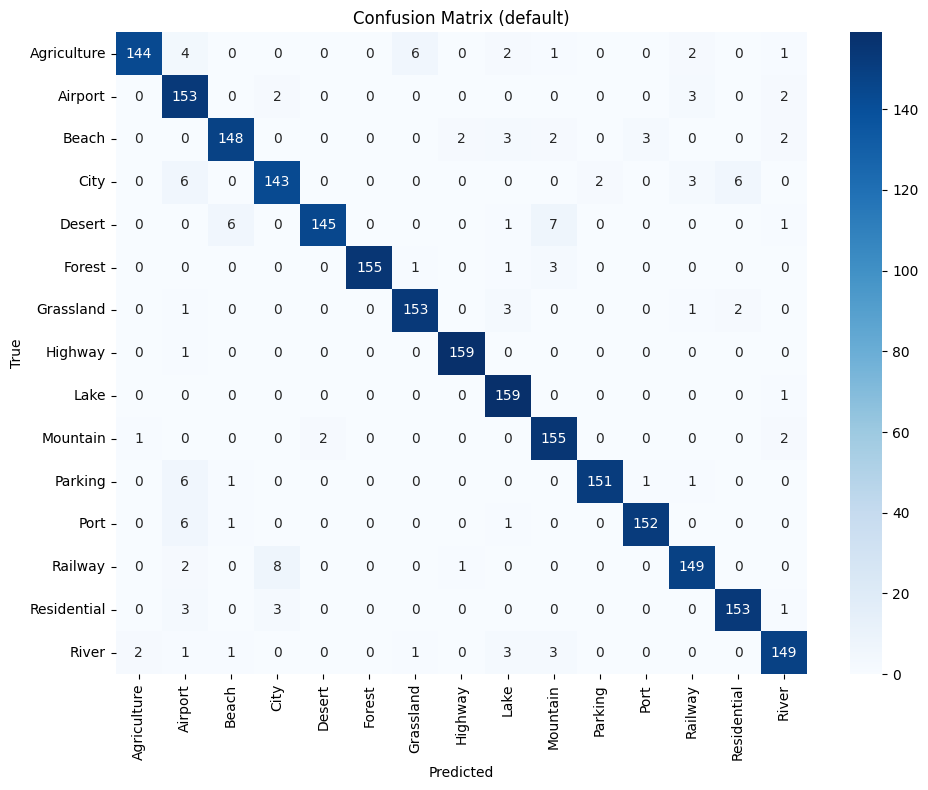


=== Confusion Matrix for strategy: extensive ===


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


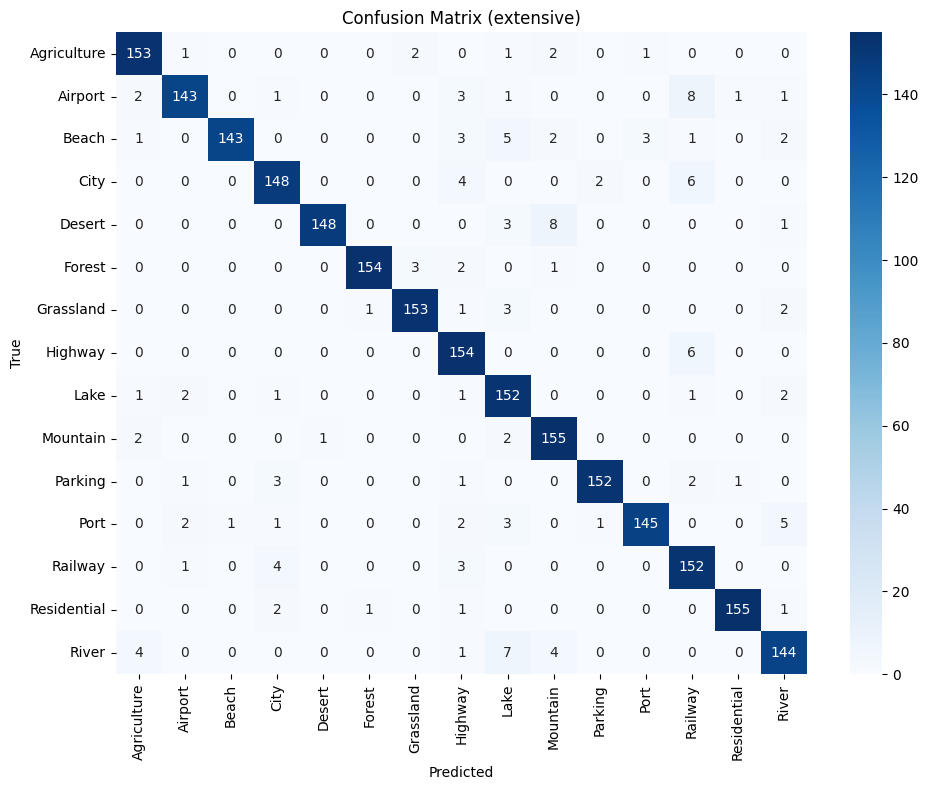

In [10]:
strategies = ['minimal', 'default', 'extensive']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for strat in strategies:
    print(f"\n=== Confusion Matrix for strategy: {strat} ===")
    
    # 1. 重新创建测试集的 DataLoader
    # 注意：这里不需要重新训练，split_ratio、batch_size、augmentation_strategy
    # 需要和训练时完全一致
    _, _, test_loader, classes = create_dataloaders(
        root_dir=DATA_DIR,
        batch_size=BATCH,
        split_ratio=SPLIT,
        augmentation_strategy=strat,
        random_seed=42,
        num_workers=0,
        verbose=False  # 不打印日志
    )
    
    # 2. 构建模型并加载已保存的最佳权重
    model = build_model(len(classes)).to(device)
    model.load_state_dict(torch.load(f'best_{strat}.pth', map_location=device))
    model.eval()
    
    # 3. 在测试集上收集真实标签和预测标签
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    # 4. 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 5. 可视化
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({strat})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()